BTech Project
Om Unhale
210070058



References used for this code :

(1) https://github.com/yutinyang/DWAN/tree/main

(2) Chat-GPT


'dwtmodel.zip' file is used from : https://github.com/yutinyang/DWAN/tree/main/dwtmodel

The 'archive.zip' contains the dataset used : https://github.com/sartajbhuvaji/brain-tumor-classification-dataset

In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
import patoolib

In [ ]:
patoolib.extract_archive("dwtmodel.zip")

INFO patool: Extracting dwtmodel.zip ...
INFO:patool:Extracting dwtmodel.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_ofzkqstk -- dwtmodel.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_ofzkqstk -- dwtmodel.zip
INFO patool: ... dwtmodel.zip extracted to `dwtmodel'.
INFO:patool:... dwtmodel.zip extracted to `dwtmodel'.


'dwtmodel'

In [ ]:
patoolib.extract_archive("archive.zip")

INFO patool: Extracting archive.zip ...
INFO:patool:Extracting archive.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_bjk0hkhz -- archive.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_bjk0hkhz -- archive.zip
INFO patool: ... archive.zip extracted to `archive'.
INFO:patool:... archive.zip extracted to `archive'.


'archive'

In [ ]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.8 MB/s eta 0:00:00


#To perform DWT and extract LL LH HL HH component from image

In [ ]:
import torch
from torch.autograd import Function

class DWTFunction_2D(Function):
    @staticmethod
    def forward(ctx, input, matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1):
        ctx.save_for_backward(matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1)
        L = torch.matmul(matrix_Low_0, input)
        H = torch.matmul(matrix_High_0, input)
        LL = torch.matmul(L, matrix_Low_1)
        LH = torch.matmul(L, matrix_High_1)
        HL = torch.matmul(H, matrix_Low_1)
        HH = torch.matmul(H, matrix_High_1)
        return LL, LH, HL, HH

    @staticmethod
    def backward(ctx, grad_LL, grad_LH, grad_HL, grad_HH):
        matrix_Low_0, matrix_Low_1, matrix_High_0, matrix_High_1 = ctx.saved_tensors
        grad_L = torch.add(torch.matmul(grad_LL, matrix_Low_1.t()), torch.matmul(grad_LH, matrix_High_1.t()))
        grad_H = torch.add(torch.matmul(grad_HL, matrix_Low_1.t()), torch.matmul(grad_HH, matrix_High_1.t()))
        grad_input = torch.add(torch.matmul(matrix_Low_0.t(), grad_L), torch.matmul(matrix_High_0.t(), grad_H))
        return grad_input, None, None, None, None



In [ ]:
import torch
import numpy as np
import pywt
import math
from torch import nn

class DWT_2D(nn.Module):
    """
    input: the 2D data to be decomposed -- (N, C, H, W)
    output -- lfc: (N, C, H/2, W/2)
              hfc_lh: (N, C, H/2, W/2)
              hfc_hl: (N, C, H/2, W/2)
              hfc_hh: (N, C, H/2, W/2)
    """
    def __init__(self, wavename):
        """
        2D discrete wavelet transform (DWT) for 2D image decomposition
         wavename: pywt.wavelist(); used in code'biorx.y'.
        """
        super(DWT_2D, self).__init__()
        wavelet = pywt.Wavelet(wavename)
        self.band_low = wavelet.rec_lo
        self.band_high = wavelet.rec_hi
        assert len(self.band_low) == len(self.band_high)
        self.band_length = len(self.band_low)
        assert self.band_length % 2 == 0
        self.band_length_half = math.floor(self.band_length / 2)

    def get_matrix(self):
        """
        generating the matrices: \mathcal{L}, \mathcal{H}
        :return: self.matrix_low = \mathcal{L}, self.matrix_high = \mathcal{H}
        """
        L1 = np.max((self.input_height, self.input_width))
        L = math.floor(L1 / 2)
        matrix_h = np.zeros((L, L1 + self.band_length - 2))
        matrix_g = np.zeros((L1 - L, L1 + self.band_length - 2))
        end = None if self.band_length_half == 1 else (-self.band_length_half + 1)

        index = 0
        for i in range(L):
            for j in range(self.band_length):
                matrix_h[i, index + j] = self.band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(self.band_length):
                matrix_g[i, index + j] = self.band_high[j]
            index += 2
        matrix_g_0 = matrix_g[0:(self.input_height - math.floor(self.input_height / 2)), 0:(self.input_height + self.band_length - 2)]
        matrix_g_1 = matrix_g[0:(self.input_width - math.floor(self.input_width / 2)), 0:(self.input_width + self.band_length - 2)]

        matrix_h_0 = matrix_h_0[:, (self.band_length_half - 1):end]
        matrix_h_1 = matrix_h_1[:, (self.band_length_half - 1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_g_0 = matrix_g_0[:, (self.band_length_half - 1):end]
        matrix_g_1 = matrix_g_1[:, (self.band_length_half - 1):end]
        matrix_g_1 = np.transpose(matrix_g_1)

        if torch.cuda.is_available():
            self.matrix_low_0 = torch.Tensor(matrix_h_0).cuda()
            self.matrix_low_1 = torch.Tensor(matrix_h_1).cuda()
            self.matrix_high_0 = torch.Tensor(matrix_g_0).cuda()
            self.matrix_high_1 = torch.Tensor(matrix_g_1).cuda()
        else:
            self.matrix_low_0 = torch.Tensor(matrix_h_0)
            self.matrix_low_1 = torch.Tensor(matrix_h_1)
            self.matrix_high_0 = torch.Tensor(matrix_g_0)
            self.matrix_high_1 = torch.Tensor(matrix_g_1)

    def forward(self, input):
        """
        input_lfc = \mathcal{L} * input * \mathcal{L}^T
        input_hfc_lh = \mathcal{H} * input * \mathcal{L}^T
        input_hfc_hl = \mathcal{L} * input * \mathcal{H}^T
        input_hfc_hh = \mathcal{H} * input * \mathcal{H}^T
        :param input: the 2D data to be decomposed
        :return: the low-frequency and high-frequency components of the input 2D data
        """
        assert len(input.size()) == 4
        self.input_height = input.size()[-2]
        self.input_width = input.size()[-1]
        self.get_matrix()
        return DWTFunction_2D.apply(input, self.matrix_low_0, self.matrix_low_1, self.matrix_high_0, self.matrix_high_1)



##To get (LL + LH + HL + HH) &  CAT (LL, HL + LH + HH) from LL HH LH HL data

In [ ]:
class Downsamplewave(nn.Module):
    def __init__(self, wavename = 'haar'):
        super(Downsamplewave, self).__init__()
        # self.dwt = DWT_2D_tiny(wavename = wavename) #return LL
        self.dwt = DWT_2D(wavename = wavename)   #return LL,LH,HL,HH

    def forward(self, input):
        # LL = self.dwt(input)
        # return LL
        LL,LH,HL,HH = self.dwt(input)
        return torch.cat([LL,LH+HL+HH],dim=1)

class Downsamplewave1(nn.Module):
    def __init__(self, wavename = 'haar'):
        super(Downsamplewave1, self).__init__()
        # self.dwt = DWT_2D_tiny(wavename = wavename) #return LL
        self.dwt = DWT_2D(wavename = wavename)   #return LL,LH,HL,HH

    def forward(self, input):
        # LL = self.dwt(input)
        # return LL
        # inputori= input
        LL,LH,HL,HH = self.dwt(input)
        LL = LL+LH+HL+HH
        result = torch.sum(LL, dim=[2, 3])  # x:torch.Size([64, 256, 56, 56])
        return result  ###torch.Size([64, 256])

 # n,c,h,w = x.shape

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dwtmodel.waveletpro import Downsamplewave,Downsamplewave1

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        # self.att = Waveletatt(in_planes=planes)
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.att(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class Waveletatt(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution=224, in_planes=3, norm_layer=nn.LayerNorm):
        super().__init__()
        wavename = 'haar'
        self.input_resolution = input_resolution

        # self.dim = dim
        # self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        # self.norm = norm_layer(4 * dim)
        # self.low_dim = nn.Conv2d(4 * in_planes, in_planes,kernel_size=3, stride=1,padding=1)
        self.downsamplewavelet = nn.Sequential(*[nn.Upsample(scale_factor=2),Downsamplewave1(wavename=wavename)])
        # self.downsamplewavelet = Downsamplewave(wavename=wavename)
        # self.conv1 = nn.Conv2d()
        # self.ac = nn.Sigmoid()
        # self.bn = nn.BatchNorm2d(in_planes)
        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // 2, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_planes // 2, in_planes, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: B, H*W, C
        """
        xori = x
        B, C, H, W= x.shape
        x = x.view(B, H, W, C)
        x = x.permute(0, 3, 2, 1)
        # x0,x1,x2,x3 = Downsamplewave(x)
        ##x0,x1,x2,x3= self.downsamplewavelet(x)
        y = self.downsamplewavelet(x)
        y = self.fc(y).view(B, C, 1, 1)  # torch.Size([64, 256])-->torch.Size([64, 256, 1, 1])
        y = xori * y.expand_as(xori)
        return y

class Waveletattspace(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution=224, in_planes=3, norm_layer=nn.LayerNorm):
        super().__init__()
        wavename = 'haar'
        self.input_resolution = input_resolution

        # self.dim = dim
        # self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        # self.norm = norm_layer(4 * dim)
        # self.low_dim = nn.Conv2d(4 * in_planes, in_planes,kernel_size=3, stride=1,padding=1)
        self.downsamplewavelet = nn.Sequential(*[nn.Upsample(scale_factor=2),Downsamplewave(wavename=wavename)])
        # self.downsamplewavelet = Downsamplewave(wavename=wavename)
        # self.conv1 = nn.Conv2d()
        # self.ac = nn.Sigmoid()
        # self.bn = nn.BatchNorm2d(in_planes)
        self.fc = nn.Sequential(
            # nn.Linear(in_planes, in_planes // 2, bias=False),
            # nn.ReLU(inplace=True),
            # nn.Linear(in_planes // 2, in_planes, bias=False),
            nn.Conv2d(in_planes*2, in_planes//2, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes//2, in_planes,kernel_size=1,padding= 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: B, H*W, C
        """
        xori = x
        B, C, H, W= x.shape
        # H, W = self.input_resolution
        # B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"
        # assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = x.view(B, H, W, C)
        x = x.permute(0, 3, 2, 1)
        y = self.downsamplewavelet(x)
        y = self.fc(y) # torch.Size([64, 256])-->torch.Size([64, 256, 1, 1])
        # y = self.fc(y).view(B, C, 1, 1)  # torch.Size([64, 256])-->torch.Size([64, 256, 1, 1])
        y = xori * y.expand_as(xori)
        return y


class ResNetCIFAR(nn.Module):
    """This is a variation of ResNet for CIFAR database.
    Indeed, the network defined in Sec 4.2 performs poorly on CIFAR-100.
    This network is similar to table 1 without the stride and max pooling
    to avoid to reduce too much the input size.

    This modification have been inspired by DenseNet implementation
    for CIFAR databases.
    """
    def __init__(self, layers, num_classes=1000, levels=4):
        block = BasicBlock
        self.inplanes = 64
        super(ResNetCIFAR, self).__init__()

        self.levels = levels
        if(self.levels != 4 and self.levels != 3):
            raise "Impossible to use this number of levels"

        # Same as Densetnet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.att1 = Waveletatt(in_planes=64)
        self.attspace1 = Waveletattspace(in_planes=64)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1)
        self.att2 = Waveletatt(in_planes=128)
        self.attspace2 = Waveletattspace(in_planes=128)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        if self.levels == 4:
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
            self.avgpool = nn.AvgPool2d(4, stride=1)
            self.fc = nn.Linear(12800, num_classes)
        else:
            # 3 levels
            self.avgpool = nn.AvgPool2d(8, stride=1)
            self.fc = nn.Linear(256 * block.expansion, num_classes)

        self.att3 = Waveletatt(in_planes=256)
        self.att4 = Waveletatt(in_planes=512)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.att2(x)
        x = self.attspace2(x)
        # x = self.att2(x)
        x = self.layer3(x)
        # x = self.att3(x)
        if self.levels == 4:
            x = self.layer4(x)
            # x = self.att4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class ResNetCIFARNormal(nn.Module):

    def __init__(self, layers, num_classes=1000):
        block = BasicBlock
        self.inplanes = 16
        super(ResNetCIFARNormal, self).__init__()
        # raise "It is not possible to use this network"
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
        #                       bias=False)
        #self.bn1 = nn.BatchNorm2d(64)
        #self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Same as Densetnet
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.layer1 = self._make_layer(block, 16, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        #x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

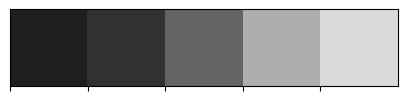

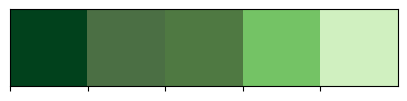

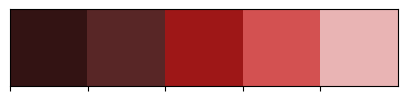

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

##Data preparation for model training

In [ ]:

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Training data
for i in labels:
    folderPath = os.path.join('/content/archive/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

# Testing data
for i in labels:
    folderPath = os.path.join('/content/archive/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 74/74 [00:00<00:00, 370.74it/s]


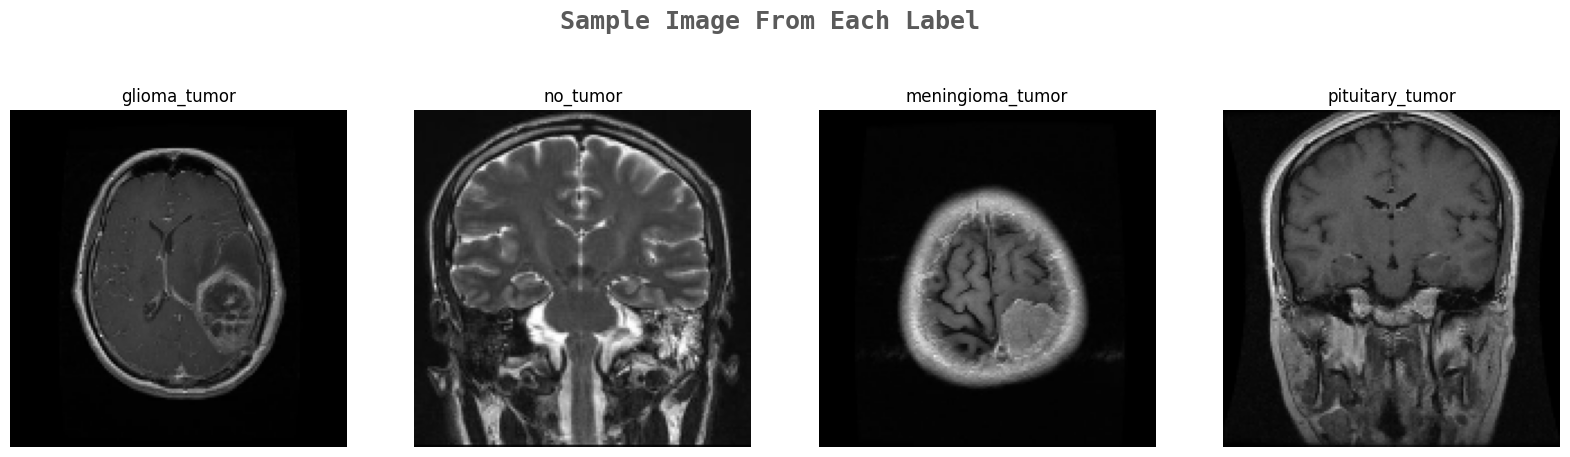

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
print(X_train.shape)

(3264, 150, 150, 3)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)


In [ ]:
print(X_train.shape)
print(y_train.shape)


(2611, 150, 150, 3)
(2611,)


In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train.shape

(2611, 4)

In [ ]:
X_train.shape

(2611, 150, 150, 3)

#Model training

In [ ]:
import cv2
import torch
import numpy as np

# Resize images
X_train_resized = np.array([cv2.resize(img, (32, 32)) for img in X_train])
X_train_resized = torch.tensor(X_train_resized).permute(0, 3, 1, 2).float()  # Convert to [N, C, H, W] format

# Resize images
X_test_resized = np.array([cv2.resize(img, (32, 32)) for img in X_test])
X_test_resized = torch.tensor(X_test_resized).permute(0, 3, 1, 2).float()  # Convert to [N, C, H, W] format

# Convert y_train to tensor
y_train_tensor = torch.tensor(y_train).float()  # Ensure y_train is the right dtype for your loss function
y_test_tensor = torch.tensor(y_test).float()  # Ensure y_train is the right dtype for your loss function

In [ ]:
from torch.utils.data import Dataset, DataLoader

class BrainTumorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the dataset and dataloader
train_dataset = BrainTumorDataset(X_train_resized, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create the dataset and dataloader
test_dataset = BrainTumorDataset(X_test_resized, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you already have your model and data (ResNetCIFAR and DataLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = ResNetCIFAR(layers=[2, 2, 2, 2], num_classes=4).to(device)  # Adjust layers as needed
criterion = nn.CrossEntropyLoss()  # For multi-class classification, use BCEWithLogitsLoss for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming DataLoader is set up and X_train and y_train are already in correct formats
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
epochs = 20  # Adjust number of epochs as needed

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure inputs and labels are float32 for compatibility
        inputs = inputs.float()  # Ensure inputs are float32
        labels = labels.argmax(dim=1)  # Convert one-hot to class indices for multi-class classification

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # No need to cast outputs to float

        # Backward pass
        loss.backward()

        # Gradient update
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # Correct prediction count

    # Print stats after each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Optionally save the model
torch.save(model.state_dict(), 'resnet_cifar_model.pth')


Epoch [1/20], Loss: 1.5151, Accuracy: 49.02%
Epoch [2/20], Loss: 0.9058, Accuracy: 63.58%
Epoch [3/20], Loss: 0.7596, Accuracy: 68.82%
Epoch [4/20], Loss: 0.5645, Accuracy: 76.33%
Epoch [5/20], Loss: 0.4599, Accuracy: 82.34%
Epoch [6/20], Loss: 0.3932, Accuracy: 85.68%
Epoch [7/20], Loss: 0.3852, Accuracy: 85.37%
Epoch [8/20], Loss: 0.2342, Accuracy: 91.00%
Epoch [9/20], Loss: 0.1358, Accuracy: 95.44%
Epoch [10/20], Loss: 0.1213, Accuracy: 95.71%
Epoch [11/20], Loss: 0.1524, Accuracy: 94.18%
Epoch [12/20], Loss: 0.0673, Accuracy: 97.59%
Epoch [13/20], Loss: 0.0618, Accuracy: 97.78%
Epoch [14/20], Loss: 0.0543, Accuracy: 98.09%
Epoch [15/20], Loss: 0.1010, Accuracy: 96.74%
Epoch [16/20], Loss: 0.0561, Accuracy: 98.28%
Epoch [17/20], Loss: 0.0583, Accuracy: 98.35%
Epoch [18/20], Loss: 0.0682, Accuracy: 97.47%
Epoch [19/20], Loss: 0.0538, Accuracy: 98.20%
Epoch [20/20], Loss: 0.0293, Accuracy: 99.16%


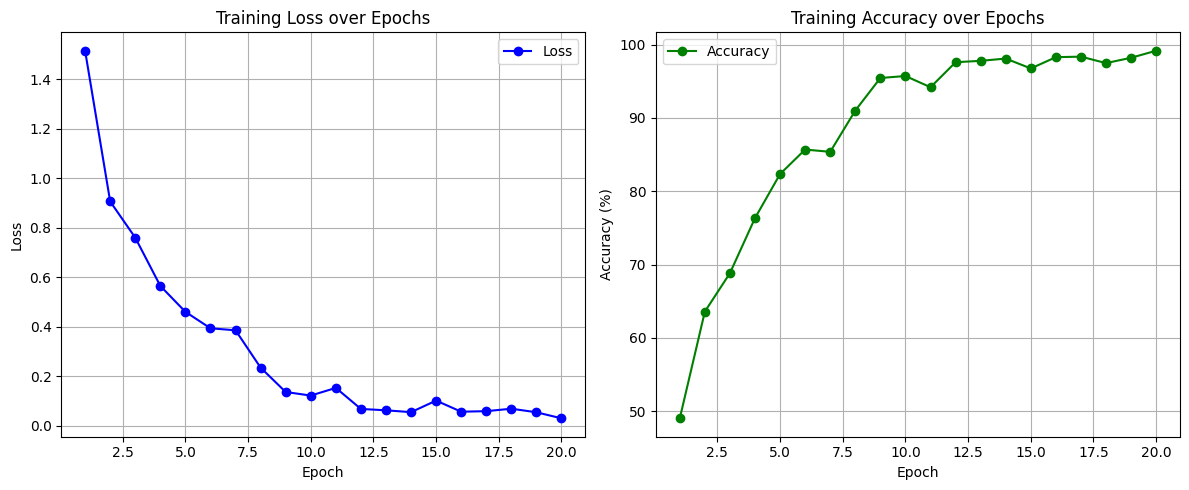

In [ ]:
import matplotlib.pyplot as plt

# Data from the training process
epochs = list(range(1, 21))
loss_values = [1.5151, 0.9058, 0.7596, 0.5645, 0.4599, 0.3932, 0.3852, 0.2342, 0.1358, 0.1213,
               0.1524, 0.0673, 0.0618, 0.0543, 0.1010, 0.0561, 0.0583, 0.0682, 0.0538, 0.0293]
accuracy_values = [49.02, 63.58, 68.82, 76.33, 82.34, 85.68, 85.37, 91.00, 95.44, 95.71,
                   94.18, 97.59, 97.78, 98.09, 96.74, 98.28, 98.35, 97.47, 98.20, 99.16]

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, marker='o', color='g', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid()

# Show both plots
plt.tight_layout()
plt.show()


In [ ]:
import torch

# Assuming you have the trained model saved as 'resnet_cifar_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = ResNetCIFAR(layers=[2, 2, 2, 2], num_classes=4).to(device)  # Adjust layers as needed
model.load_state_dict(torch.load('resnet_cifar_model.pth'))
model.eval()  # Set the model to evaluation mode

# Test the model on the test dataset
def evaluate(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs are float32
            inputs = inputs.float()
            labels = labels.argmax(dim=1)  # Convert one-hot to class indices

            # Forward pass
            outputs = model(inputs)

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()  # Correct prediction count

    accuracy = 100. * correct / total
    return accuracy

# Evaluate on the test dataset
test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')


<ipython-input-68-e9bb12788157>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet_cifar_model.pth'))


Test Accuracy: 90.05%


<Figure size 800x800 with 0 Axes>

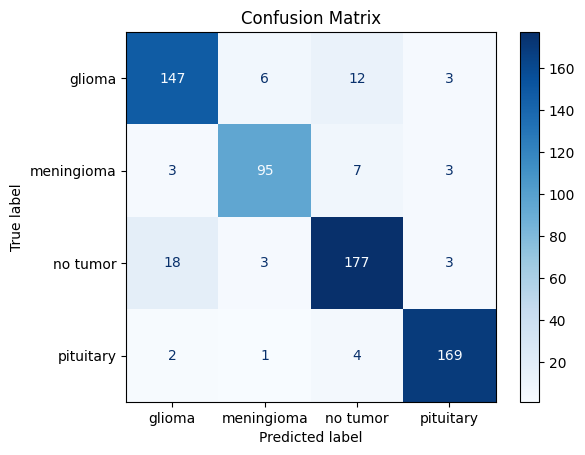

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate model and get predictions and true labels
def evaluate_with_confusion_matrix(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs are float32 and convert labels from one-hot to class indices
            inputs = inputs.float()
            labels = labels.argmax(dim=1)

            # Forward pass
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Run evaluation to get predictions and true labels
all_preds, all_labels = evaluate_with_confusion_matrix(model, test_loader, device)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma', 'meningioma', 'no tumor', 'pituitary'])

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


#Comparing with resnet model Without dual attention block

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you already have your model and data (ResNetCIFAR and DataLoader)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, and optimizer
model = ResNetCIFARNormal(layers=[2, 2, 2, 2], num_classes=4).to(device)  # Adjust layers as needed
criterion = nn.CrossEntropyLoss()  # For multi-class classification, use BCEWithLogitsLoss for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Assuming DataLoader is set up and X_train and y_train are already in correct formats
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
epochs = 10  # Adjust number of epochs as needed

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure inputs and labels are float32 for compatibility
        inputs = inputs.float()  # Ensure inputs are float32
        labels = labels.argmax(dim=1)  # Convert one-hot to class indices for multi-class classification

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # No need to cast outputs to float

        # Backward pass
        loss.backward()

        # Gradient update
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()  # Correct prediction count

    # Print stats after each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Optionally save the model
torch.save(model.state_dict(), 'resnet_cifarnormal_model.pth')


Epoch [1/10], Loss: 0.8949, Accuracy: 62.18%
Epoch [2/10], Loss: 0.5512, Accuracy: 78.47%
Epoch [3/10], Loss: 0.3277, Accuracy: 88.58%
Epoch [4/10], Loss: 0.2049, Accuracy: 92.64%
Epoch [5/10], Loss: 0.1303, Accuracy: 95.70%
Epoch [6/10], Loss: 0.0891, Accuracy: 97.17%
Epoch [7/10], Loss: 0.0805, Accuracy: 97.60%
Epoch [8/10], Loss: 0.0465, Accuracy: 98.88%
Epoch [9/10], Loss: 0.0392, Accuracy: 99.07%
Epoch [10/10], Loss: 0.0376, Accuracy: 98.92%


In [ ]:
import torch

# Assuming you have the trained model saved as 'resnet_cifar_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = ResNetCIFARNormal(layers=[2, 2, 2, 2], num_classes=4).to(device)  # Adjust layers as needed
model.load_state_dict(torch.load('resnet_cifarnormal_model.pth'))
model.eval()  # Set the model to evaluation mode

# Test the model on the test dataset
def evaluate(model, test_loader, device):
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs are float32
            inputs = inputs.float()
            labels = labels.argmax(dim=1)  # Convert one-hot to class indices

            # Forward pass
            outputs = model(inputs)

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()  # Correct prediction count

    accuracy = 100. * correct / total
    return accuracy

# Evaluate on the test dataset
test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 82.58%


<ipython-input-28-907a479e3be3>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet_cifarnormal_model.pth'))
